# 可视化类激活热力图的实践
## -教材： pp143-145
## -项目目标：用Grad-CAM技术以热力图形式将VGG16对于非洲象输入图片的分类决策可视化
## -模型：预训练的VGG16
## -输入：非洲象测试图片
## -输出：叠加在原始图片上的类激活热力图

## -步骤：指定入--->定损数--->求梯度--->乘梯度--->染画布-->可视化

## 1 指定入，指定一张待分类图片输入到模型

### 1.1 加载预训练的VGG16模型
#### 备注：如果预训练的VGG16模型下载速度较慢，可提前通过以下地址XXXX将该模型下载到本地C:\Users\Administrator\.keras\models下。以后在运行该模型，会直接从本地加载，而不会从网络下载。

In [100]:
from keras.applications.vgg16 import VGG16
from keras import backend as K

K.clear_session()

# 特别注意，在之前的实验中，我们都把顶层的分类器丢弃掉了，include_top = False
model = VGG16(weights='imagenet')

### 1.2 加载指定分类图片

In [101]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'D:/2-AI读书学习笔记/99-dataset-lib/creative_commons_elephant.jpg'

### 1.3 图片预处理
### 一转、二扩、三标

In [102]:
# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# 一转，`x` is a float32 Numpy array of shape (224, 224, 3)
x0 = image.img_to_array(img)

# 二扩，We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x1 = np.expand_dims(x0, axis=0)

# 三标，Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x1)

In [103]:
x0.shape

(224, 224, 3)

In [104]:
x1.shape

(1, 224, 224, 3)

In [105]:
x.shape

(1, 224, 224, 3)

In [106]:
x1

array([[[[ 71.32     ,  96.221    , 129.061    ],
         [ 71.32     ,  97.221    , 127.061    ],
         [ 71.32     ,  97.221    , 127.061    ],
         ...,
         [ 64.32     ,  84.221    , 116.061    ],
         [ 65.32     ,  85.221    , 117.061    ],
         [ 63.32     ,  83.221    , 115.061    ]],

        [[ 72.32     ,  97.221    , 130.061    ],
         [ 72.32     ,  98.221    , 128.061    ],
         [ 72.32     ,  98.221    , 128.061    ],
         ...,
         [ 64.32     ,  84.221    , 116.061    ],
         [ 63.32     ,  83.221    , 115.061    ],
         [ 63.32     ,  83.221    , 115.061    ]],

        [[ 72.32     ,  98.221    , 128.061    ],
         [ 72.32     ,  98.221    , 128.061    ],
         [ 71.32     ,  97.221    , 127.061    ],
         ...,
         [ 65.32     ,  85.221    , 117.061    ],
         [ 63.32     ,  83.221    , 115.061    ],
         [ 64.32     ,  84.221    , 116.061    ]],

        ...,

        [[-19.68     ,  -2.7789993, -3

In [107]:
x

array([[[[129.061    ,  96.221    ,  71.32     ],
         [127.061    ,  97.221    ,  71.32     ],
         [127.061    ,  97.221    ,  71.32     ],
         ...,
         [116.061    ,  84.221    ,  64.32     ],
         [117.061    ,  85.221    ,  65.32     ],
         [115.061    ,  83.221    ,  63.32     ]],

        [[130.061    ,  97.221    ,  72.32     ],
         [128.061    ,  98.221    ,  72.32     ],
         [128.061    ,  98.221    ,  72.32     ],
         ...,
         [116.061    ,  84.221    ,  64.32     ],
         [115.061    ,  83.221    ,  63.32     ],
         [115.061    ,  83.221    ,  63.32     ]],

        [[128.061    ,  98.221    ,  72.32     ],
         [128.061    ,  98.221    ,  72.32     ],
         [127.061    ,  97.221    ,  71.32     ],
         ...,
         [117.061    ,  85.221    ,  65.32     ],
         [115.061    ,  83.221    ,  63.32     ],
         [116.061    ,  84.221    ,  64.32     ]],

        ...,

        [[-39.939003 ,  -2.7789993, -1

### 1.4 预测图片分类

In [108]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


## 2 求梯度

In [109]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

In [110]:
# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

In [111]:
#调用后端的梯度计算张量库，对最后一个卷积层的输出求梯度，即对african_elephant_output求last_conv_layer.output的导数
#https://tensorflow.google.cn/api_docs/python/tf/keras/backend/gradients?hl=en
#y为african_elephant_output，表示第386号分类的预测输出结果,shape (batch_size,)
#x为last_conv_layer.output，表示最后一个卷积层的输出，shape (batch_size, 14, 14, 512)
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

In [112]:
#梯度标准化，即求各通道平均值，平均数,即对每一层 14 x 14的矩阵求均值, (14,14, 512) ----> (512,)
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [113]:
# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [114]:
# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

## 3 乘梯度，即获取各点位对模型最终分类决策的重要程度，即类激活图

In [115]:
# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [116]:
conv_layer_output_value.shape

(14, 14, 512)

In [117]:
heatmap.shape

(14, 14)

In [118]:
heatmap

array([[ 6.01113641e-07,  3.37042593e-07,  7.02134002e-07,
         7.18175102e-07,  5.66080587e-07,  8.07919776e-09,
         4.42156534e-10,  4.19646398e-07,  8.61231399e-07,
         7.52879885e-07,  5.14896442e-07,  5.64627726e-07,
         6.44854424e-07,  1.28782767e-06],
       [ 3.52439429e-07,  2.15537259e-08,  1.77414961e-07,
         5.07918081e-08, -1.43059253e-07,  3.71407452e-07,
        -5.13823579e-08, -1.35607479e-07, -1.46345243e-07,
         5.04512855e-07,  6.67014149e-07,  5.09364781e-07,
         4.40863118e-07,  4.92572042e-07],
       [ 9.01172598e-07,  4.39845223e-07,  3.54812414e-07,
         2.41868065e-07,  3.47371611e-07, -3.44723276e-07,
         1.85434601e-07,  2.28381009e-06,  1.17541754e-06,
         1.95664234e-06,  1.29706882e-06,  1.44266210e-06,
         1.10572023e-06,  1.29681348e-06],
       [ 1.17693560e-06,  5.46440447e-07,  1.99985152e-07,
         5.09722611e-08,  3.65129239e-07,  2.23252869e-07,
         1.28830754e-06,  3.04170089e-06,  2.

#### 打印乘梯度后的图像

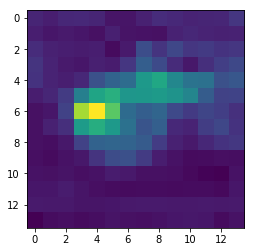

In [119]:
import matplotlib.pyplot as plt
#原始图像，也可以展现，负数自动剪裁掉
plt.imshow(heatmap)

#### 为了增强可视化效果，对乘梯度后图像进行二次处理

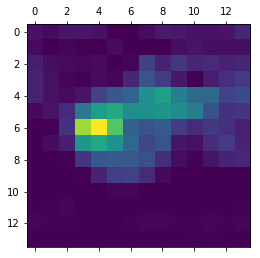

In [120]:
#为了将热力图可视化，去除所有负数
heatmap = np.maximum(heatmap, 0)
#归一化处理
heatmap /= np.max(heatmap)
#展现
plt.matshow(heatmap)

## 4 染画布，获取热力效果图

### 4.1 调整热力图尺寸，与原始图像保持一致

In [121]:
#读取原始图像
import cv2
import numpy as np
#test = cv2.imread("D:/2-AI读书学习笔记/99-dataset-lib/creative_commons_elephant.jpg")
#包含中文路径时，仅能使用cv2.imdecode
test = cv2.imdecode(np.fromfile("D:/2-AI读书学习笔记/99-dataset-lib/creative_commons_elephant.jpg",dtype=np.uint8),-1)
cv2.imshow('image',test)
cv2.waitKey(0)

-1

In [122]:
#图片尺寸
#特别注意，在image中用size作为属性，在cv2中用shape作为属性
test.shape

(600, 899, 3)

#### 使用cv2.resize()调整尺寸

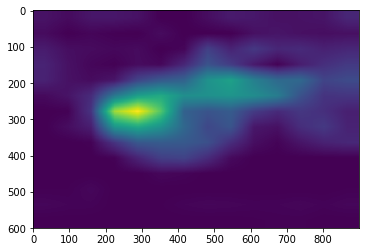

In [123]:
import cv2

#调整热图尺寸，与原图保持一致，resize()
#heatmap为[0,1]之间的浮点数，特别注意：cv2.resize(img, (x轴向长度，y轴向长度))
heatmap_test = cv2.resize(heatmap, (test.shape[1], test.shape[0]))
plt.imshow(heatmap_test)

In [124]:
heatmap_test

array([[0.05023634, 0.05023634, 0.05023634, ..., 0.10762649, 0.10762649,
        0.10762649],
       [0.05023634, 0.05023634, 0.05023634, ..., 0.10762649, 0.10762649,
        0.10762649],
       [0.05023634, 0.05023634, 0.05023634, ..., 0.10762649, 0.10762649,
        0.10762649],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [125]:
heatmap_test.shape

(600, 899)

### 4.2 将类激活热力图数组转换为(0,255)之间

In [126]:
#将heatmap数组转换为（0,255）之间的无符号的unit8数值
heatmap_test = np.uint8(255 * heatmap_test)

In [127]:
heatmap_test

array([[12, 12, 12, ..., 27, 27, 27],
       [12, 12, 12, ..., 27, 27, 27],
       [12, 12, 12, ..., 27, 27, 27],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [128]:
heatmap_test.shape

(600, 899)

### 4.3 使用cv2.COLORMAP_JET对类激活图进行热力渲染

In [129]:
#将热力图转换为喷射效果
#cv2.applyColorMap选项可参考 https://docs.opencv.org/4.0.1/d3/d50/group__imgproc__colormap.html#gadf478a5e5ff49d8aa24e726ea6f65d15
#cv2.COLORMAP_JET https://docs.opencv.org/4.0.1/d3/d50/group__imgproc__colormap.html#ga9a805d8262bcbe273f16be9ea2055a65
heatmap_test = cv2.applyColorMap(heatmap_test, cv2.COLORMAP_JET)

In [130]:
heatmap_test

array([[[176,   0,   0],
        [176,   0,   0],
        [176,   0,   0],
        ...,
        [236,   0,   0],
        [236,   0,   0],
        [236,   0,   0]],

       [[176,   0,   0],
        [176,   0,   0],
        [176,   0,   0],
        ...,
        [236,   0,   0],
        [236,   0,   0],
        [236,   0,   0]],

       [[176,   0,   0],
        [176,   0,   0],
        [176,   0,   0],
        ...,
        [236,   0,   0],
        [236,   0,   0],
        [236,   0,   0]],

       ...,

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]]

In [131]:
heatmap_test.shape

(600, 899, 3)

### 4.4 以一定渲染强度将类激活热力图与原始图像叠加在一起

In [132]:
#将热力图与原始图像叠加， 0.5表示渲染强度, 有超出（0,255）范围的，如果需要可视化，则需要clip裁剪
superimposed_img_test = heatmap_test * 0.5 + test

In [133]:
superimposed_img_test

array([[[322., 214., 196.],
        [321., 213., 195.],
        [321., 213., 195.],
        ...,
        [338., 201., 188.],
        [338., 201., 188.],
        [338., 201., 188.]],

       [[322., 214., 196.],
        [322., 214., 196.],
        [321., 213., 195.],
        ...,
        [337., 200., 187.],
        [337., 200., 187.],
        [337., 200., 187.]],

       [[322., 214., 196.],
        [322., 214., 196.],
        [321., 213., 195.],
        ...,
        [337., 200., 187.],
        [337., 200., 187.],
        [337., 200., 187.]],

       ...,

       [[163., 150., 142.],
        [121., 110., 101.],
        [112., 101.,  91.],
        ...,
        [120.,  96.,  91.],
        [149., 125., 120.],
        [144., 120., 115.]],

       [[130., 121., 112.],
        [108., 100.,  89.],
        [129., 124., 110.],
        ...,
        [139., 115., 110.],
        [145., 121., 116.],
        [126., 102.,  97.]],

       [[139., 130., 121.],
        [117., 109.,  98.],
        [130., 1

In [134]:
superimposed_img_test.shape

(600, 899, 3)

## 5 可视化

In [135]:
#解决cv2在写入路径中不识别中文路径问题
_path = "D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/vgg16_elephant_heatmap_new.jpg"
cv2.imencode('.jpg',superimposed_img_test)[1].tofile(_path)

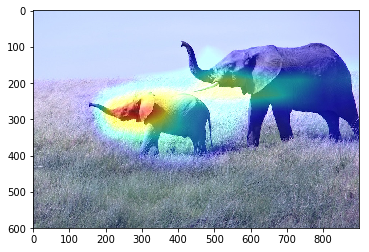

In [136]:
#以plt形式读取热力图或cv2.imdecode
plt.imshow(image.load_img('D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/vgg16_elephant_heatmap_new.jpg'))